<a href="https://colab.research.google.com/github/cammylexi/CS2341-Assignment-3/blob/main/Lab5_Llanes_McPhaul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparation

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gregorut/videogamesales")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/videogamesales


## Feature Definition
This section defines and prepares the class variables for analysis or modeling. Each variable is assigned a proper representation based on its type (categorical or numerical).

| Feature | Type| Representation | Explanation |
|-||||
| **Rank**|Numerical|`int`| Rank of the game based on global sales. |
| **Name**| Categorical | `string` (can be dropped or used as ID)   | Generally not useful for modeling unless performing NLP. |
| **Platform**|Categorical|One-hot encoded or Label encoded|One-hot if few platforms, label encoding if too many.|
| **Year**|Numerical|`int`(or `float` if needed)|Year of release. Can be scaled or normalized if required.|
| **Genre**|Categorical|One-hot encoded|Categorical genre feature with no ordinal relationship.|
| **Publisher**|Categorical|One-hot encoded or Label encoded|Use label encoding if too many publishers.|
| **NA_Sales**|Numerical|`float`|North America sales (in millions).|
| **EU_Sales**|Numerical|`float`|Europe sales (in millions).|
| **JP_Sales**|Numerical|`float`|Japan sales (in millions).|
| **Other_Sales**|Numerical|`float`|Sales in the rest of the world (in millions).|
| **Global_Sales**|Numerical|`float`|Total worldwide sales (in millions). Often used as target variable.|

### Summary

- **Numerical (int/float)**: `Rank`, `Year`, `NA_Sales`, `EU_Sales`, `JP_Sales`, `Other_Sales`, `Global_Sales`
- **Categorical (One-hot or Label encoded)**: `Platform`, `Genre`, `Publisher`
- **Dropped or Optional**: `Name` (only necessary for identification or NLP-based tasks)


In [ ]:
import pandas as pd

df = pd.read_csv(path + "/vgsales.csv")
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## Final Dataset Description
**Numerical features**: Rank, Year, regional sales values — standardized using z-scaling.

**Categorical features**: Platform, Genre, Publisher — one-hot encoded into binary variables.

**Dimensionality reduction**: PCA applied to reduce the high-dimensional space to fewer components while retaining 95% of variance.

**Target**: Global_Sales (float) — continuous variable, for regression.

**Removed features**: Name (not useful for modeling), and any rows missing the target value

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Drop 'Name' — not useful for modeling
df = df.drop(columns=['Name'])

# Drop rows missing the target variable (Global_Sales)
df = df.dropna(subset=['Global_Sales'])

# Define features and target
X = df.drop(columns=['Global_Sales'])
y = df['Global_Sales']

# Identify columns by type
numeric_features = ['Rank', 'Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
categorical_features = ['Platform', 'Genre', 'Publisher']

# Create preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # use sparse_output=False for sklearn >=1.2
])

# Combine into full preprocessing step
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Optional: add PCA for dimensionality reduction
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95))  # keep 95% variance
])

# Apply transformations
X_processed = pipeline.fit_transform(X)


##Cross-Product Features
Cross-product (or interaction) features are useful when the relationship between two variables could produce a non-linear effect on the outcome.

Justification:

**Platform x Genre**: Certain game genres perform better on specific platforms (e.g., FPS on PC, Sports on consoles).

**Publisher x Genre**: Some publishers are known for dominating specific genres (e.g., EA and Sports), so this interaction may capture brand-specific strength.

These interaction terms allow the model to learn patterns that wouldn't be visible using individual variables alone.

In [ ]:
# Example 1: Platform x Genre
df['Platform_Genre'] = df['Platform'] + '_' + df['Genre']

# Example 2: Publisher x Genre (some publishers specialize in specific genres)
df['Publisher_Genre'] = df['Publisher'] + '_' + df['Genre']

## Evaluation Metric
Since the task is regression, we want a metric that reflects error magnitude and penalizes large errors. The following are good choices:

### Chosen Metrics:
**Mean Absolute Error (MAE)**: Interpretable in the same units as sales (millions), robust to outliers.

**Root Mean Squared Error (RMSE)**: Penalizes large errors more; useful if high sales errors are especially bad.

**R² Score**: Measures overall fit; 1.0 means perfect prediction.

## Data Splitting Strategy
Option: 10-Fold Cross Validation (CV)

### Justification:
10-fold CV provides a good balance between bias and variance.

Shuffling makes sure the splits are representative.

This simulates real-world model performance across different subsets of games.

In practice, you don’t know which games you'll predict — cross-validation mimics this by testing across many unseen subsets.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = LinearRegression()
cv_scores = cross_val_score(model, X_processed, y, cv=kf, scoring='neg_mean_absolute_error')

#Modeling

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

In [ ]:
def build_wide_and_deep_model(input_dim, deep_layers=[64, 32], name="WideDeep"):
    # Input
    input_layer = keras.Input(shape=(input_dim,))

    # Wide branch (simple linear)
    wide = layers.Dense(1)(input_layer)

    # Deep branch
    deep = input_layer
    for units in deep_layers:
        deep = layers.Dense(units, activation='relu')(deep)
    deep = layers.Dense(1)(deep)

    # Combine wide and deep
    combined = layers.Add()([wide, deep])

    # Build model
    model = keras.Model(inputs=input_layer, outputs=combined, name=name)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

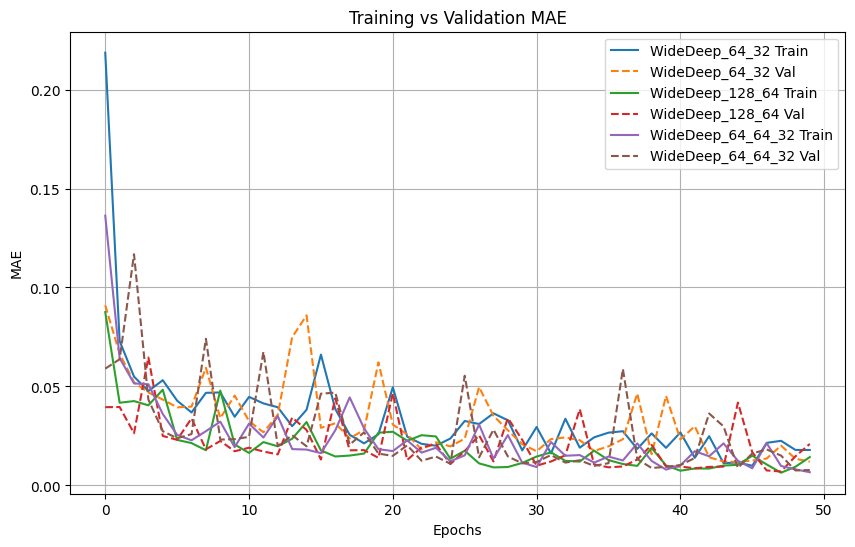

In [ ]:
def plot_history(histories, title='Training vs Validation MAE'):
    plt.figure(figsize=(10,6))
    for label, history in histories.items():
        plt.plot(history.history['mae'], label=f'{label} Train')
        plt.plot(history.history['val_mae'], linestyle='--', label=f'{label} Val')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Build and train 3 models with different layer setups
histories = {}
configs = {
    "WideDeep_64_32": [64, 32],
    "WideDeep_128_64": [128, 64],
    "WideDeep_64_64_32": [64, 64, 32]
}

for name, layers_config in configs.items():
    model = build_wide_and_deep_model(input_dim=X_train.shape[1], deep_layers=layers_config, name=name)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_val, y_val), verbose=0)
    histories[name] = history

# Plot results
plot_history(histories)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

def evaluate_model_cv(X, y, deep_layers, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        model = build_wide_and_deep_model(X.shape[1], deep_layers)
        model.fit(X[train_index], y.iloc[train_index], epochs=25, batch_size=32, verbose=0)
        loss, mae = model.evaluate(X[test_index], y.iloc[test_index], verbose=0)
        scores.append(mae)
    return np.mean(scores), np.std(scores)

# Evaluate two model setups
mean1, std1 = evaluate_model_cv(X_processed, y, [64, 32])
mean2, std2 = evaluate_model_cv(X_processed, y, [64, 64, 32])

print(f"Model 1 [64,32] - MAE: {mean1:.3f} ± {std1:.3f}")
print(f"Model 2 [64,64,32] - MAE: {mean2:.3f} ± {std2:.3f}")

Model 1 [64,32] - MAE: 0.017 ± 0.004
Model 2 [64,64,32] - MAE: 0.042 ± 0.029


In [ ]:
def build_mlp_model(input_dim, hidden_layers=[64, 32], name="MLP"):
    input_layer = keras.Input(shape=(input_dim,))
    x = input_layer
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu')(x)
    output = layers.Dense(1)(x)
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# Train Wide+Deep best model
wide_deep_model = build_wide_and_deep_model(X_train.shape[1], [64, 64, 32])
wide_deep_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
wd_preds = wide_deep_model.predict(X_val)

# Train MLP
mlp_model = build_mlp_model(X_train.shape[1], [64, 64, 32])
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
mlp_preds = mlp_model.predict(X_val)

# Residual variance
wd_residuals = y_val - wd_preds.ravel()
mlp_residuals = y_val - mlp_preds.ravel()

print(f"WD Residual variance: {np.var(wd_residuals):.4f}")
print(f"MLP Residual variance: {np.var(mlp_residuals):.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
WD Residual variance: 0.0011
MLP Residual variance: 0.0026


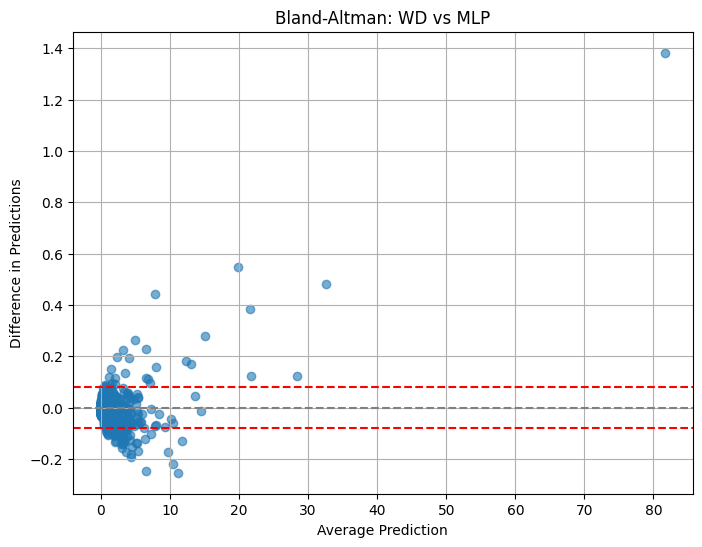

In [ ]:
import matplotlib.pyplot as plt

def bland_altman_plot(y_true, y_pred1, y_pred2, label1="WD", label2="MLP"):
    diff = y_pred1 - y_pred2
    avg = (y_pred1 + y_pred2) / 2
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)

    plt.figure(figsize=(8,6))
    plt.scatter(avg, diff, alpha=0.6)
    plt.axhline(mean_diff, color='gray', linestyle='--')
    plt.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--')
    plt.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--')
    plt.title(f'Bland-Altman: {label1} vs {label2}')
    plt.xlabel('Average Prediction')
    plt.ylabel('Difference in Predictions')
    plt.grid(True)
    plt.show()

bland_altman_plot(y_val.values, wd_preds.ravel(), mlp_preds.ravel())

#Exceptional Work